This IPython Notebook illustrates the use of the **`openmc.mgxs.Library`** class. The `Library` class is designed to automate the calculation of multi-group cross sections for use cases with one or more domains, cross section types, and/or nuclides. In particular, this Notebook illustrates the following features:

* Calculation of multi-group cross sections for a **fuel assembly**
* Automated creation, manipulation and storage of `MGXS` with **`openmc.mgxs.Library`**
* **Validation** of multi-group cross sections with **[OpenMOC](https://mit-crpg.github.io/OpenMOC/)**
* Steady-state pin-by-pin **fission rates comparison** between OpenMC and [OpenMOC](https://mit-crpg.github.io/OpenMOC/)

**Note:** This Notebook was created using [OpenMOC](https://mit-crpg.github.io/OpenMOC/) to verify the multi-group cross-sections generated by OpenMC. In order to run this Notebook in its entirety, you must have [OpenMOC](https://mit-crpg.github.io/OpenMOC/) installed on your system, along with OpenCG to convert the OpenMC geometries into OpenMOC geometries. In addition, this Notebook illustrates the use of [Pandas](http://pandas.pydata.org/) `DataFrames` to containerize multi-group cross section data.

## Generate Input Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import openmc
import openmc.mgxs as mgxs
import openmoc
import openmoc.process
from openmoc.opencg_compatible import get_openmoc_geometry
from openmoc.materialize import load_openmc_mgxs_lib


%matplotlib inline

/home/travis/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Load the model from the TREAT summary

In [2]:
# Extract the geometry from an existing summary
summ = openmc.Summary("test_model/summary.h5")
geom = summ.openmc_geometry
mats = summ.materials

## Create an MGXS Library

First, define a 2-group structure using the built-in `EnergyGroups` class.

In [3]:
# 2-group approximation
two_groups = mgxs.EnergyGroups()
two_groups.group_edges = np.array([0., 0.625, 20.0e6])

Next, we will instantiate an `openmc.mgxs.Library` for the energy groups with our the fuel assembly geometry.

In [4]:
# Initialize an 2-group MGXS Library for OpenMOC
mgxs_lib = mgxs.Library(geom)
mgxs_lib.energy_groups = two_groups

Now, we must specify to the `Library` which types of cross sections to compute. In particular, the following are the multi-group cross section `MGXS` subclasses that are mapped to string codes accepted by the `Library` class:

* `TotalXS` (`"total"`)
* `TransportXS` (`"transport"`)
* `NuTransportXS` (`"nu-transport"`)
* `AbsorptionXS` (`"absorption"`)
* `CaptureXS` (`"capture"`)
* `FissionXS` (`"fission"`)
* `NuFissionXS` (`"nu-fission"`)
* `KappaFissionXS` (`"kappa-fission"`)
* `ScatterXS` (`"scatter"`)
* `NuScatterXS` (`"nu-scatter"`)
* `ScatterMatrixXS` (`"scatter matrix"`)
* `NuScatterMatrixXS` (`"nu-scatter matrix"`)
* `Chi` (`"chi"`)
* `ChiPrompt` (`"chi prompt"`)
* `InverseVelocity` (`"inverse-velocity"`)
* `PromptNuFissionXS` (`"prompt-nu-fission"`)
* `DelayedNuFissionXS` (`"delayed-nu-fission"`)
* `ChiDelayed` (`"chi-delayed"`)
* `Beta` (`"beta"`)

In this case, let's create the multi-group cross sections needed to run an OpenMOC simulation to verify the accuracy of our cross sections. In particular, we will define `"transport"`, `"nu-fission"`, `'"fission"`, `"nu-scatter matrix"` and `"chi"` cross sections for our `Library`.

**Note**: A variety of different approximate transport-corrected total multi-group cross sections (and corresponding scattering matrices) can be found in the literature. At the present time, the `openmc.mgxs` module only supports the `"P0"` transport correction. This correction can be turned on and off through the boolean `Library.correction` property which may take values of `"P0"` (default) or `None`.

In [5]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['transport', 'nu-fission', 'fission', 'nu-scatter matrix', 'chi']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports `"material"`, `"cell"`, `"universe"`, and `"mesh"` domain types. We will use a `"cell"` domain type here to compute cross sections in each of the cells in the fuel assembly geometry.

**Note:** By default, the `Library` class will instantiate `MGXS` objects for each and every domain (material, cell or universe) in the geometry of interest. However, one may specify a subset of these domains to the `Library.domains` property. In our case, we wish to compute multi-group cross sections in each and every cell since they will be needed in our downstream OpenMOC calculation on the identical combinatorial geometry mesh.

In [6]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = 'material'

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = geom.get_all_materials()

We can easily instruct the `Library` to compute multi-group cross sections on a nuclide-by-nuclide basis with the boolean `Library.by_nuclide` property. By default, `by_nuclide` is set to `False`, but we will set it to `True` here.

In [7]:
# Compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = True

Lastly, we use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each domain and nuclide.

In [8]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

The tallies can now be export to a "tallies.xml" input file for OpenMC. 

**NOTE**: At this point the `Library` has constructed nearly 100 distinct `Tally` objects. The overhead to tally in OpenMC scales as $O(N)$ for $N$ tallies, which can become a bottleneck for large tally datasets. To compensate for this, the Python API's `Tally`, `Filter` and `Tallies` classes allow for the smart *merging* of tallies when possible. The `Library` class supports this runtime optimization with the use of the optional `merge` paramter (`False` by default) for the `Library.add_to_tallies_file(...)` method, as shown below.

In [9]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a fission rate mesh tally to compare with OpenMOC.

In [10]:
# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission', 'nu-fission']

# Add tally to collection
tallies_file.append(tally)

In [11]:
# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml("test_model/tallies.xml")

In [8]:
# Run OpenMC
openmc.run(cwd = "./test_model/")


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object by loading the 50th statepoint from `test_model/`.

In [12]:
# Load the last statepoint file
sp = openmc.StatePoint('test_model/statepoint.50.h5')

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [13]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

LookupError: Unable to get Tally

## Extracting and Storing MGXS Data

First, the `Library.get_mgxs(...)` method allows one to extract an `MGXS` object from the `Library` for a particular domain and cross section type. The following cell illustrates how one may extract the `NuFissionXS` object for the fuel cell.

**Note:** The `MGXS.get_mgxs(...)` method will accept either the domain *or* the integer domain ID of interest.

In [ ]:
# Retrieve the NuFissionXS object for the fuel cell from the library
fuel_matid = 90000
fuel_mgxs = mgxs_lib.get_mgxs(fuel_matid, 'nu-fission')

The `NuFissionXS` object supports all of the methods described previously in the `openmc.mgxs` tutorials, such as [Pandas](http://pandas.pydata.org/) `DataFrames`:
Note that since so few histories were simulated, we should expect a few division-by-error errors as some tallies have not yet scored any results.

In [35]:
df = fuel_mgxs.get_pandas_dataframe()
df

/home/travis/.miniconda3/lib/python3.5/openmc/tallies.py:1835: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']


,material,group in,nuclide,mean,std. dev.
13,90000,1,O17,0.000000e+00,0.000000e+00
14,90000,1,O16,0.000000e+00,0.000000e+00
15,90000,1,C0,0.000000e+00,0.000000e+00
16,90000,1,B11,0.000000e+00,0.000000e+00
17,90000,1,U234,6.001350e-08,3.056809e-10
18,90000,1,U235,3.028665e-04,1.717767e-06
19,90000,1,U238,5.638639e-08,4.671677e-10
20,90000,1,Fe56,0.000000e+00,0.000000e+00
21,90000,1,Fe57,0.000000e+00,0.000000e+00
22,90000,1,Fe54,0.000000e+00,0.000000e+00


Similarly, we can use the `MGXS.print_xs(...)` method to view a string representation of the multi-group cross section data.

This method is currently broken; see issue #795 on GitHub: https://github.com/mit-crpg/openmc/issues/795
For now, we will have to rely on the dataframe to view the mgxs data.

In [37]:
fuel_mgxs.print_xs()

IndexError: tuple index out of range

One can export the entire `Library` to HDF5 with the `Library.build_hdf5_store(...)` method as follows:

In [38]:
# Store the cross section data in an "mgxs/mgxs.h5" HDF5 binary file
mgxs_lib.build_hdf5_store(filename='mgxs.h5', directory='mgxs')

/home/travis/.miniconda3/lib/python3.5/openmc/tallies.py:1835: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']
/home/travis/.miniconda3/lib/python3.5/openmc/tallies.py:1836: RuntimeWarning: invalid value encountered in true_divide
  other_rel_err = data['other']['std. dev.'] / data['other']['mean']
/home/travis/.miniconda3/lib/python3.5/openmc/tallies.py:1837: RuntimeWarning: invalid value encountered in true_divide
  new_tally._mean = data['self']['mean'] / data['other']['mean']


The HDF5 store will contain the numerical multi-group cross section data indexed by domain, nuclide and cross section type. Some data workflows may be optimized by storing and retrieving binary representations of the `MGXS` objects in the `Library`. This feature is supported through the `Library.dump_to_file(...)` and `Library.load_from_file(...)` routines which use Python's [`pickle`](https://docs.python.org/2/library/pickle.html) module. This is illustrated as follows.

In [39]:
# Store a Library and its MGXS objects in a pickled binary file "mgxs/mgxs.pkl"
mgxs_lib.dump_to_file(filename='mgxs', directory='mgxs')

In [40]:
# Instantiate a new MGXS Library from the pickled binary file "mgxs/mgxs.pkl"
mgxs_lib = openmc.mgxs.Library.load_from_file(filename='mgxs', directory='mgxs')

The `Library` class may be used to leverage the energy condensation features supported by the `MGXS` class. In particular, one can use the `Library.get_condensed_library(...)` with a coarse group structure which is a subset of the original "fine" group structure as shown below.

In [41]:
# Create a 1-group structure
coarse_groups = openmc.mgxs.EnergyGroups(group_edges=[0., 20.0e6])

# Create a new MGXS Library on the coarse 1-group structure
coarse_mgxs_lib = mgxs_lib.get_condensed_library(coarse_groups)

In [43]:
# Retrieve the NuFissionXS object for the fuel cell from the 1-group library
coarse_fuel_mgxs = coarse_mgxs_lib.get_mgxs(fuel_matid, 'nu-fission')

# Show the Pandas DataFrame for the 1-group MGXS
coarse_fuel_mgxs.get_pandas_dataframe()

/home/travis/.miniconda3/lib/python3.5/openmc/tallies.py:1835: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']


,material,group in,nuclide,mean,std. dev.
0,90000,1,O17,0.000000e+00,0.000000e+00
1,90000,1,O16,0.000000e+00,0.000000e+00
2,90000,1,C0,0.000000e+00,0.000000e+00
3,90000,1,B11,0.000000e+00,0.000000e+00
4,90000,1,U234,3.950311e-08,2.230286e-10
5,90000,1,U235,3.434730e-03,3.528821e-05
6,90000,1,U238,3.370576e-08,2.956254e-10
7,90000,1,Fe56,0.000000e+00,0.000000e+00
8,90000,1,Fe57,0.000000e+00,0.000000e+00
9,90000,1,Fe54,0.000000e+00,0.000000e+00


## Verification with OpenMOC

Of course it is always a good idea to verify that one's cross sections are accurate. We can easily do so here with the deterministic transport code [OpenMOC](https://mit-crpg.github.io/OpenMOC/). We will extract an OpenCG geometry from the summary file and convert it into an equivalent OpenMOC geometry.

Note: At this time, we cannot do this for the TREAT geometry, because of `NotImplementedError: Complex cells not yet supported in OpenCG.`

In [44]:
# Create an OpenMOC Geometry from the OpenCG Geometry
openmoc_geometry = get_openmoc_geometry(mgxs_lib.opencg_geometry)

NotImplementedError: Complex cells not yet supported in OpenCG.

Now, we can inject the multi-group cross sections into the equivalent fuel assembly OpenMOC geometry. The `openmoc.materialize` module supports the loading of `Library` objects from OpenMC as illustrated below.

In [38]:
# Load the library into the OpenMOC geometry
materials = load_openmc_mgxs_lib(mgxs_lib, openmoc_geometry)

We are now ready to run OpenMOC to verify our cross-sections from OpenMC.

In [39]:
# Generate tracks for OpenMOC
track_generator = openmoc.TrackGenerator(openmoc_geometry, num_azim=32, azim_spacing=0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Importing ray tracing data from file...
[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 0.854512	res = 0.000E+00
[  NORMAL ]  Iteration 1:	k_eff = 0.802081	res = 1.520E-01
[  NORMAL ]  Iteration 2:	k_eff = 0.761887	res = 6.346E-02
[  NORMAL ]  Iteration 3:	k_eff = 0.732476	res = 5.030E-02
[  NORMAL ]  Iteration 4:	k_eff = 0.711139	res = 3.873E-02
[  NORMAL ]  Iteration 5:	k_eff = 0.696569	res = 2.918E-02
[  NORMAL ]  Iteration 6:	k_eff = 0.687626	res = 2.051E-02
[  NORMAL ]  Iteration 7:	k_eff = 0.683359	res = 1.286E-02
[  NORMAL ]  Iteration 8:	k_eff = 0.682952	res = 6.234E-03
[  NORMAL ]  Iteration 9:	k_eff = 0.685703	res = 8.636E-04
[  NORMAL ]  Iteration 10:	k_eff = 0.691013	res = 4.084E-03
[  NORMAL ]  Iteration 11:	k_eff = 0.698367	res = 7.776E-03
[  NORMAL ]  Iteration 12:	k_eff = 0.707327	res = 1.067E-02
[  NORMAL ]  Iteration 13:	k_eff = 0.717520	res = 1.285E-02
[  NORMAL ]  Iteration 14:	k_eff = 0.728629	res = 1.443E-02
[  NORMAL ]  Ite

We report the eigenvalues computed by OpenMC and OpenMOC here together to summarize our results.

In [40]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined[0]
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.025390
openmoc keff = 1.026401
bias [pcm]: 101.1


There is a non-trivial bias between the eigenvalues computed by OpenMC and OpenMOC. One can show that these biases do not converge to <100 pcm with more particle histories. For heterogeneous geometries, additional measures must be taken to address the following three sources of bias:

* Appropriate transport-corrected cross sections
* Spatial discretization of OpenMOC's mesh
* Constant-in-angle multi-group cross sections

## Flux and Pin Power Visualizations

We will conclude this tutorial by illustrating how to visualize the fission rates computed by OpenMOC and OpenMC. First, we extract volume-integrated fission rates from OpenMC's mesh fission rate tally for each pin cell in the fuel assembly.

In [41]:
# Get the OpenMC fission rate mesh tally data
mesh_tally = sp.get_tally(name='mesh tally')
openmc_fission_rates = mesh_tally.get_values(scores=['nu-fission'])

# Reshape array to 2D for plotting
openmc_fission_rates.shape = (17,17)

# Normalize to the average pin power
openmc_fission_rates /= np.mean(openmc_fission_rates)

Next, we extract OpenMOC's volume-averaged fission rates into a 2D 17x17 NumPy array.

In [42]:
# Create OpenMOC Mesh on which to tally fission rates
openmoc_mesh = openmoc.process.Mesh()
openmoc_mesh.dimension = np.array(mesh.dimension)
openmoc_mesh.lower_left = np.array(mesh.lower_left)
openmoc_mesh.upper_right = np.array(mesh.upper_right)
openmoc_mesh.width = openmoc_mesh.upper_right - openmoc_mesh.lower_left
openmoc_mesh.width /= openmoc_mesh.dimension

# Tally OpenMOC fission rates on the Mesh
openmoc_fission_rates = openmoc_mesh.tally_fission_rates(solver)
openmoc_fission_rates = np.squeeze(openmoc_fission_rates)
openmoc_fission_rates = np.fliplr(openmoc_fission_rates)

# Normalize to the average pin fission rate
openmoc_fission_rates /= np.mean(openmoc_fission_rates)

Now we can easily use Matplotlib to visualize the fission rates from OpenMC and OpenMOC side-by-side.

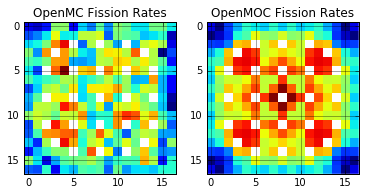

In [43]:
# Ignore zero fission rates in guide tubes with Matplotlib color scheme
openmc_fission_rates[openmc_fission_rates == 0] = np.nan
openmoc_fission_rates[openmoc_fission_rates == 0] = np.nan

# Plot OpenMC's fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(openmc_fission_rates, interpolation='none', cmap='jet')
plt.title('OpenMC Fission Rates')

# Plot OpenMOC's fission rates in the right subplot
fig2 = plt.subplot(122)
plt.imshow(openmoc_fission_rates, interpolation='none', cmap='jet')
plt.title('OpenMOC Fission Rates')